In [1]:
# package for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#package for time
from dateparser.search import search_dates
import datetime

# package for the regular expressions 
import re
import string

# package for the natural language toolkit 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud ,STOPWORDS
import spacy
import fr_core_news_md

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data = pd.read_csv('C:/Users/anis_/PycharmProjects/mywebscrap/bloom/bloom/spiders/echo.csv' , encoding = 'utf-8')
data =data.dropna().reset_index(drop=True)
data['headline'] = data['headline'].astype(str)
data['description'] = data['description'].astype(str)
data

,headline,description,date
0,Aérien : Folle descente,La Bourse anticipe un horizon très bouché pour...,Publié le 6 mars à 18h22
1,Bourses : les trois chiffres d'une journée sou...,Les marchés ont connu cette semaine une intens...,"En chiffres,Publié le 6 mars à 13h27,Mis à jou..."
2,EssilorLuxottica a tenu son cap dans la tempête,Le nouveau géant mondial de l'optique a vu son...,"Publié le 6 mars à 10h54,Mis à jour le 8 mars ..."
3,Coronavirus : vent de panique sur les marchés ...,Wall Street affiche de fortes baisses. Le CAC ...,"Publié le 6 mars à 9h58,Mis à jour le 9 mars à..."
4,"Dawn Hudson, au générique des Oscars","Juste avant la journée des femmes, l'actrice, ...","Portrait,Publié le 6 mars à 9h15"
...,...,...,...
380,Goldman Sachs veut plus de femmes et de divers...,"A partir de juillet, la banque d'affaires amér...","Publié le 24 janv. à 13h02,Mis à jour le 24 ja..."
381,Bourse : 5 questions essentielles avant d'inve...,L'investissement boursier est réputé être perf...,"Publié le 24 janv. à 8h26,Mis à jour le 24 jan..."
382,Les biotechs françaises en manque de «success ...,Malgré les mauvais résultats des biotechs en 2...,"Décryptage,Publié le 24 janv. à 7h16,Mis à jou..."
383,Assurance-vie : trois idées pour gagner plus,"La cause est entendue, quiconque souhaite rent...",Publié le 24 janv. à 7h01


In [3]:
def set_dates():
    
    date_list = []
    
    #Use the search_dates to extract the date from a string 
    for i in data['date']:
        dates = search_dates(i)
        timestamp = dates[-1][-1]
        date_list.append(timestamp)
    
    data['timestamp'] = date_list
    data['Date'] = ""    
    
    #Convert out output into a date format 
    for i, x in data['timestamp'].iteritems():
        data['Date'].loc[i] = datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').date()
    
    return data.sort_values(by = 'Date', ascending=False).reset_index(drop=True)

In [4]:
def open_vix_file():
    df_vix = pd.read_csv('VIX.csv')
    
    for i, x in df_vix['Date'].iteritems():
        df_vix['Date'].loc[i] = datetime.datetime.strptime(str(x), '%Y-%m-%d').date()
    
    return df_vix

In [5]:
def new_dataset():
    
    data = set_dates()
    df_vix = open_vix_file()
    data['Open'] = ""
    data['Close'] = ""
    
    #we look at the date of the article and we try to find the corresponding values in the Vix file
    for x in range(data.shape[0]):
        for i in range(df_vix.shape[0]):
            if(data['Date'].loc[x] == df_vix['Date'].loc[i]):
                data['Open'].loc[x] = df_vix['Open'].loc[i]
                data['Close'].loc[x] = df_vix['Close'].loc[i]
                break
    
    # If the closing value is greater than the opening value, the news is negative = 1
    data.replace('', np.nan, inplace=True)
    data = data.dropna().reset_index(drop=True)
    
    data['article'] = data['headline'].str.cat(data['description'], sep = ".")
    data['article'] = data['article'].astype(str) 
    data['label'] = ""
    
    df = data.drop('date', axis=1)
    df.drop(['headline', 'timestamp', 'description'], axis = 1, inplace = True)
    
    for x in range(df.shape[0]):
        if (df['Close'].loc[x]-df['Open'].loc[x] >= 0):
            df['label'].loc[x] = 0
        else :
            df['label'].loc[x] = 1
    
    df = df[['article', 'label']]
    
    return df

In [6]:
df_news = new_dataset()

In [7]:
df_news.head()

,article,label
0,Bourse : Réflexes naturels.Les investisseurs s...,1
1,La dynamique des «exit techs» coupée dans son ...,0
2,Coronavirus : ce qu'il faut retenir de la jour...,0
3,Bourse/Gafam : Ce qui se raréfie peut être ché...,0
4,150.000 particuliers ont fait leurs premiers p...,0


## Data Preprocessing

In [8]:
def data_cleaning(text):
    '''
    Tout mettre en minuscule, enlever les ponctuations et les chiffres
    <<< NB: NE PAS UTILISER SUR LA COLONNE DATE >>>
    '''
    stop_word = stopwords.words("french")
    text = text.lower()
    text = re.sub('\[.*?\']',' ',text)
    text = re.sub('[%s]' % re.escape(string.punctuation),' ',text)
    text = re.sub('\w*\d\w*',' ',text)
    text = text.replace(u'\xa0', u' ')
    text = text.replace('«', '').replace('»', '')
    text = ' '.join([word for word in text.split() if word not in stop_word])    
    text = " ".join(text.split())

    return text

clean = lambda df: data_cleaning(df)

In [9]:
df_news['article'] = df_news['article'].apply(clean)

In [10]:
df_news

,article,label
0,bourse réflexes naturels investisseurs loin av...,1
1,dynamique exit techs coupée élan nombre rachat...,0
2,coronavirus faut retenir journée avril sans su...,0
3,bourse gafam raréfie peut être chéri croissanc...,0
4,particuliers fait leurs premiers bourse depuis...,0
...,...,...
333,propositions patronat lutter contre activistes...,1
334,volatilité bourse envie retour grande absente ...,1
335,vélo intérieur vendeur découvert bad buzz grou...,1
336,sanofi ordonnance royale quand nouveau plan st...,1


In [11]:
def racine_word():
    data = new_dataset()
    data['article'] = data['article'].apply(clean)
    nlp = spacy.load('fr_core_news_md')
    data['text'] = ""
    
    for x in range(data.shape[0]):
        text = nlp(data['article'].loc[x])
        l = []
        for token in text:
            l.append(token.lemma_)
        data['text'].loc[x] = ' '.join(l)
    
    return data

In [28]:
df = racine_word()

In [29]:
df.head()

,article,label,text
0,bourse réflexes naturels investisseurs loin av...,1,bourse réflexe naturel investisseur loin avoir...
1,dynamique exit techs coupée élan nombre rachat...,0,dynamique exit techs coupée élan nombre rachat...
2,coronavirus faut retenir journée avril sans su...,0,coronavirus falloir retenir journée avril sans...
3,bourse gafam raréfie peut être chéri croissanc...,0,bourse gafam raréfier pouvoir être chéri crois...
4,particuliers fait leurs premiers bourse depuis...,0,particulier faire leur premier bourse depuis d...


In [30]:
print("Notre base de donnée est constitué de ", df['text'].apply(lambda x: len(x.split(' '))).sum(), "mots")

Notre base de donnée est constitué de  9368 mots


In [31]:
X = df.text
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=['0','1']))

accuracy 0.6372549019607843
              precision    recall  f1-score   support

           0       0.40      0.11      0.18        35
           1       0.66      0.91      0.77        67

    accuracy                           0.64       102
   macro avg       0.53      0.51      0.47       102
weighted avg       0.57      0.64      0.57       102



In [56]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge',random_state=42)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=['0','1']))

accuracy 0.5980392156862745
              precision    recall  f1-score   support

           0       0.40      0.34      0.37        35
           1       0.68      0.73      0.71        67

    accuracy                           0.60       102
   macro avg       0.54      0.54      0.54       102
weighted avg       0.58      0.60      0.59       102



In [39]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver = 'liblinear')),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=['0','1']))

accuracy 0.6470588235294118
              precision    recall  f1-score   support

           0       0.40      0.06      0.10        35
           1       0.66      0.96      0.78        67

    accuracy                           0.65       102
   macro avg       0.53      0.51      0.44       102
weighted avg       0.57      0.65      0.55       102



Train on 212 samples, validate on 24 samples
Epoch 1/20
212/212 [==============================] - 0s 1ms/step - loss: 0.6953 - accuracy: 0.5472 - val_loss: 0.6850 - val_accuracy: 0.5833
Epoch 2/20
212/212 [==============================] - 0s 101us/step - loss: 0.6445 - accuracy: 0.7264 - val_loss: 0.6970 - val_accuracy: 0.4167
Epoch 3/20
212/212 [==============================] - 0s 102us/step - loss: 0.6012 - accuracy: 0.8443 - val_loss: 0.7067 - val_accuracy: 0.4167
Epoch 4/20
212/212 [==============================] - 0s 96us/step - loss: 0.5600 - accuracy: 0.9057 - val_loss: 0.7127 - val_accuracy: 0.3750
Epoch 5/20
212/212 [==============================] - 0s 98us/step - loss: 0.5073 - accuracy: 0.9575 - val_loss: 0.7169 - val_accuracy: 0.4583
Epoch 6/20
212/212 [==============================] - 0s 102us/step - loss: 0.4582 - accuracy: 0.9481 - val_loss: 0.7206 - val_accuracy: 0.4167
Epoch 7/20
212/212 [==============================] - 0s 94us/step - loss: 0.4189 - accuracy: 0

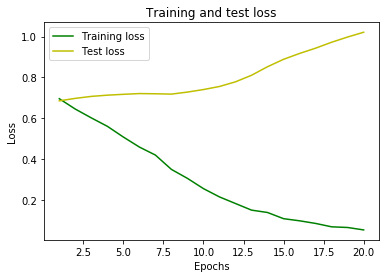

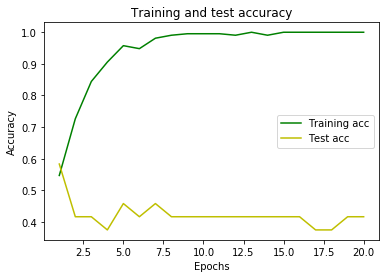

In [26]:
import itertools
import os

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .7)
train_text = df['text'][:train_size]
train_label = df['label'][:train_size]

test_text = df['text'][train_size:]
test_label = df['label'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_text) # only fit on train

x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

encoder = LabelEncoder()
encoder.fit(train_label)
y_train = encoder.transform(train_label)
y_test = encoder.transform(test_label)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 64
epochs = 20

# Build the model
model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Test acc')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()